# Invert single survey line for a thin plate
<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_single_line_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cofi

from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient, 
    plot_predicted_profile, 
    plot_observed_profile,
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

# Background

This example inverts a single survey line of VTEM max data using the inline and vertical  component for a thin plate target. The dip azimuth of the plate is in the direction of the survey line and we only seek to recover the plate dip, the plate width and the location of the plate along the survey line. The forward problem and model setup is described [here](./thin_plate_inversion.ipynb).

## Problem definition

Here we create a survey that consists of 12 fdicucal forming a survey line in the direction of the dip azimuth of the thin plate. This allows us to infer more than just a single plate parameter.We are esstially inferring a 2D model and can only hoep to directly recover apretemrs of the thin patle that map dirrectly into the the 2D mdoel . That is we can constrain its depth, postion along the flight direction, dip and width, and they beocme our declared model paramters that are exposed to CoFI.

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
n_transmitters = (tx_max - tx_min - 1) // tx_interval + 1
tx = numpy.arange(tx_min, tx_max, tx_interval)

survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": numpy.array([100]*n_transmitters),                    # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
}

In [5]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip", "peast", "ptop", "pwdth2"])

['pdip', 'peast', 'ptop', 'pwdth2']


In [6]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'peast', 'ptop', 'pwdth2']

In [7]:
true_param_value = numpy.array([60, 175, 30, 90])

**Generate synthetic data**

In [8]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

## Run the inversion

**Initialise a model for inversion**

In [9]:
init_param_value = numpy.array([50, 155, 35, 70])

**Define helper functions for inversion**

In [10]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

def my_log_likelihood(model):
    return -0.5 * my_objective(model)

def my_log_prior(m):    # uniform distribution
    for i in range(len(m)):
        if m[i] < m_min[i] or m[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [11]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [12]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG", options={"maxiter": 10},callback=PerIterationCallbackFunction())

**Define CoFI inversion**

In [13]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 5163.4378653908625
[ 56.11594457 172.11751859  25.35756044  67.1505715 ]


## Plotting

**Plotting the data**

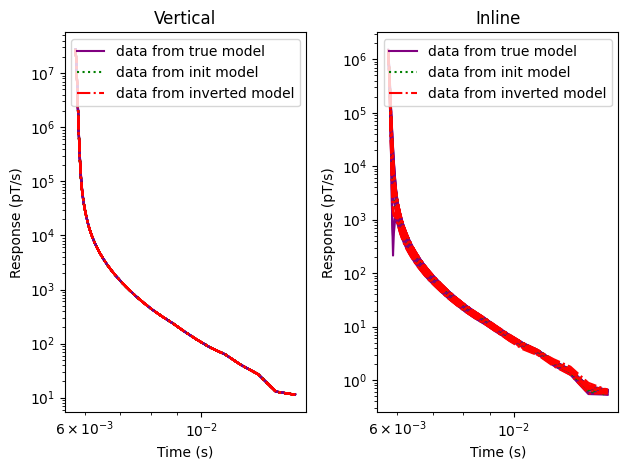

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2)
plot_transient(true_param_value, forward, "data from true model", ax1, ax2, color="purple")
plot_transient(init_param_value, forward, "data from init model", ax1, ax2, color="green", linestyle=":")
plot_transient(my_result.model, forward, "data from inverted model", ax1, ax2, color="red", linestyle="-.")
ax1.legend(loc="upper center")
ax2.legend(loc="upper center")
ax1.set_title("Vertical")
ax2.set_title("Inline")
plt.tight_layout()

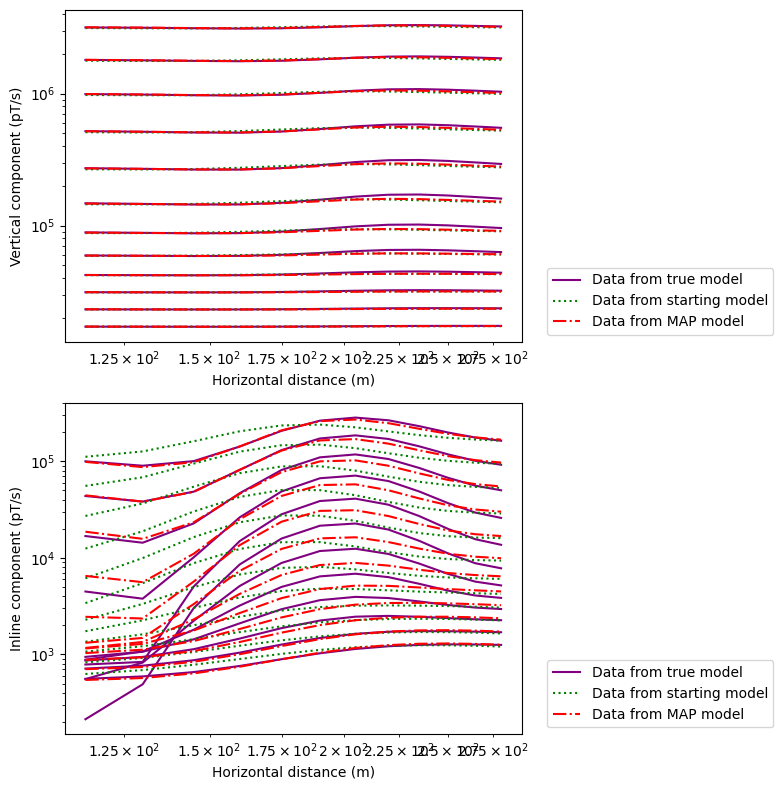

In [15]:
idx_to_plot = numpy.arange(8, 20)       # subset of numpy.arange(0, 44)

_, (ax1 ,ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_predicted_profile(true_param_value, forward, "Data from true model", gate_idx=idx_to_plot, ax=ax1, cmp='vertical', color="purple")
plot_predicted_profile(init_param_value, forward, "Data from starting model", gate_idx=idx_to_plot, ax=ax1,cmp='vertical', color="green", linestyle=":")
plot_predicted_profile(my_result.model, forward, "Data from MAP model", gate_idx=idx_to_plot, ax=ax1, cmp='vertical',color="red", linestyle="-.")
ax1.legend(bbox_to_anchor=(1.04, 0), loc="lower left")

plot_predicted_profile(true_param_value, forward, "Data from true model", gate_idx=idx_to_plot, ax=ax2, cmp='inline', color="purple")
plot_predicted_profile(init_param_value, forward, "Data from starting model", gate_idx=idx_to_plot, ax=ax2,cmp='inline', color="green", linestyle=":")
plot_predicted_profile(my_result.model, forward, "Data from MAP model", gate_idx=idx_to_plot, ax=ax2, cmp='inline',color="red", linestyle="-.")

ax2.legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()


**Plotting the model**

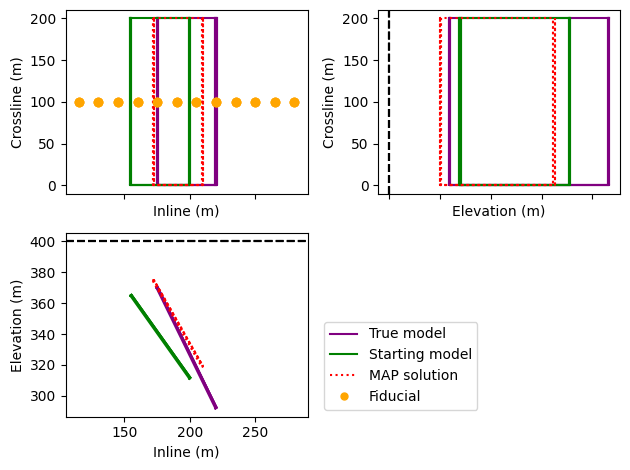

In [16]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP solution", linestyle="dotted"
)
plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

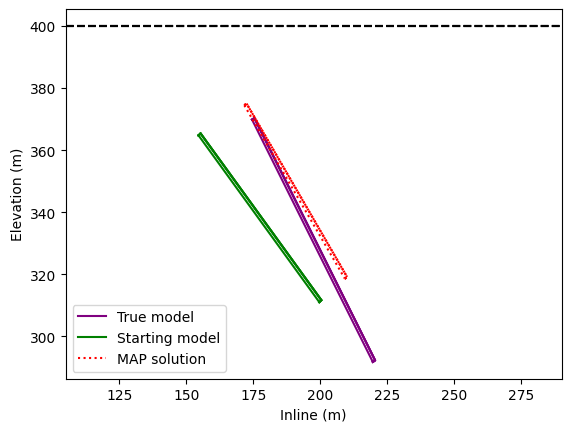

In [17]:
_, ax = plt.subplots(1, 1)
plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="True model")
plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="Starting model")
plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="MAP solution", linestyle="dotted")
ax.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [18]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
